### Correction des paramètres d'orientation de la caméra

In [1]:
%matplotlib widget
import geopandas as gpd
import logging
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import pyvista as pv

from georefcam.camera_model import CTCameraModel
from georefcam.dem import ASCIIGridDEM
from georefcam.georefcam import GeoRefCam, project_points_to_crs
from pathlib import Path
from PIL import Image

# logging.basicConfig(level=logging.DEBUG)

# Définition des dossiers contenant les données nécessaires à l'exécution du notebook (À ÉDITER)

In [2]:
carto_dir = Path("../../data/terrain/BDALTI/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D007_2022-12-16/BDALTIV2")
camdata_dir = Path("../../data/pyronear_cam_data")
donnees_dir = Path("1_DONNEES_LIVRAISON_2023-01-00224/BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D007")
dalles_dir = Path("3_SUPPLEMENTS_LIVRAISON_2023-01-00224/BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D007/")
terrain_dir = "../../data/terrain/"

cam_name = "brison_4"
test_img_name = "pyronear_brison_4_2023_07_04T06_07_57.jpg"
gcp_filepath = "../../georefcam/df_annotations.csv"

# Récupération des données de localisation/orientation de la caméra

Création d'un geodataframe des dalles dans la carto contenant une caméra (problème si les dalles recherchées sont à cheval sur deux cartos, cas relativement improbable d'une caméra couvrant la bordure entre deux départements) :

In [3]:
dalles_shape_file = Path("dalles.shp")
gdf_dalles = gpd.read_file(carto_dir / dalles_dir / dalles_shape_file)

Création d'un geodataframe des caméras utilisées à l'aide du fichier de référence 'API_DATA - devices.csv' :

In [4]:
cam_file = camdata_dir / "API_DATA - devices.csv"
df_cams = pd.read_csv(cam_file)
gdf_cams = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_cams.lon, df_cams.lat, crs="WGS84"), data=df_cams)

Sélection d'une caméra et récupération de ses informations, sélection du fichier de dalle contenant sa localisation

In [5]:
cam_info = gdf_cams[gdf_cams.login == cam_name].squeeze()
test_img_path = camdata_dir / cam_name / test_img_name
test_img = Image.open(test_img_path)
test_img_res = test_img.size

gdf_dalles_wgs84 = gdf_dalles.to_crs("WGS84")
dalle_cam = gdf_dalles[gdf_dalles_wgs84.geometry.contains(cam_info.geometry)].squeeze()
nom_dalle = dalle_cam.NOM_DALLE
dalle_file = carto_dir / donnees_dir / Path(f"{nom_dalle}.asc")

# Création d'une caméra géoréférencée avec `georefcam`

Création d'un DEM avec `ASCIIGridDEM`

In [6]:
dem = ASCIIGridDEM(dalle_file, gdf_dalles.crs)
dem.build_pcd(sample_step=5)
dem.build_mesh()

Sauvegarde du DEM en cas de crash du kernel (il peut aussi facilement être recréé à l'aide des cellules précédentes)

In [7]:
with open(terrain_dir+"dem_asc.pkl", "wb") as f:
    pickle.dump(dem, f)

Création d'un modèle de caméra orientée et localisée avec `CTCameraModel`

In [10]:
cam_view_x_angle, cam_view_y_angle = 87, 44
cam_roll = 0

cam_model = CTCameraModel(
    test_img_res,
    cam_view_x_angle,
    cam_view_y_angle,
    cam_info.azimuth,
    cam_info.pitch,
    cam_roll,
    cam_info.lat,
    cam_info.lon,
    cam_info.elevation,
)

Création du modèle de caméra géoréférencée

In [11]:
geocam = GeoRefCam(cam_model, dem)

# Évaluation de la projection d'un ensemble de GCP

In [12]:
df_annot_gcp = pd.read_csv(gcp_filepath)
df_annot_gcp = df_annot_gcp.rename({"ele": "alt"}, axis=1).astype({"posx": int, "posy": int, "lat": float, "lon": float, "alt": float})
df_annot_gcp
gdf_annot_gcp = gpd.GeoDataFrame(df_annot_gcp, geometry=gpd.points_from_xy(df_annot_gcp.lon, df_annot_gcp.lat, df_annot_gcp.alt), crs="WGS84")
gdf_annot_gcp

,Unnamed: 0,posx,posy,lat,lon,alt,geometry
0,0,651,328,44.609620,4.098371,1448.0,POINT Z (4.09837 44.60962 1448.00000)
1,1,789,319,44.612899,4.126470,1458.0,POINT Z (4.12647 44.61290 1458.00000)
2,2,978,409,44.577702,4.188103,643.0,POINT Z (4.18810 44.57770 643.00000)
3,3,1190,310,44.612280,4.185187,1316.0,POINT Z (4.18519 44.61228 1316.00000)


Sélection d'un ensemble de GCPs et génération de leurs rayons de projection dans le repère monde

In [13]:
test_gcp_idx = 2
pixel_points = gdf_annot_gcp.loc[test_gcp_idx, ["posx", "posy"]]
# pixel_points = gdf_annot_gcp[["posx", "posy"]]

rays = geocam.camera_model.project_pixel_points_to_world_rays(pixel_points)
rays

array([[[ 44.54515457,  44.67704565],
        [  4.21653414,   4.14014126],
        [780.        ,   0.        ]]])

Calcul de l'intersection entre les rayons et le MNT

In [16]:
filtered_inter_points, filtered_inter_triangles, df_ray = geocam.cast_rays(
                 rays, check_crs=True, min_d_intersection_m=50, return_df_ray=True, cast_method="seq", max_cp_time_s=30)

df_ray

,ori_x,ori_y,ori_z,dest_x,dest_y,dest_z,inter_x,inter_y,inter_z,n_tri,dist_o
n_ray,,,,,,,,,,,
0,796636.658666,6.383642e+06,780.0,790357.216371,6.398201e+06,0.0,794734.625,6388052.0,543.740845,62893,4808.187345


Sauvegarde des résultats (si le kernel crashe, charger les pickle dans un autre notebook et y exécuter la cellule de plot)

In [17]:
with open(terrain_dir+"asc_ctcam_proj.pkl", "wb") as f:
     pickle.dump([df_ray, gdf_annot_gcp, gdf_dalles, test_gcp_idx], f)

In [18]:
with open(terrain_dir+"asc_ctcam_proj.pkl", "rb") as f:
    df_ray, gdf_annot_gcp, gdf_dalles, test_gcp_idx = pickle.load(f)

Récupération des coordonnées GPS du point d'intersection

In [19]:
project_points_to_crs(df_ray.loc[0, ["inter_x", "inter_y", "inter_z"]].to_numpy(), dem.crs, "wgs84")

array([[ 44.58510878,   4.19343255, 543.74084473]])

Plot de la projection

In [16]:
# plot_margin_m = 1000

# alts_meshgrid = dem.pcd

# target_point = np.array(list(gdf_annot_gcp.to_crs(gdf_dalles.crs).loc[test_gcp_idx, "geometry"].coords)[0])
# origin = df_ray.loc[0, ["ori_x", "ori_y", "ori_z"]].to_numpy(dtype=float)
# destination = df_ray.loc[0, ["dest_x", "dest_y", "dest_z"]].to_numpy(dtype=float)
# inter_point = df_ray.loc[0, ["inter_x", "inter_y", "inter_z"]].to_numpy(dtype=float)

# intersection_found = ~np.isnan(inter_point[0])

# if intersection_found:
#     points_of_interest = np.vstack((target_point, origin, inter_point))
# else:
#     points_of_interest = np.vstack((target_point, origin))
# (x_min, y_min, _) = points_of_interest.min(axis=0) - plot_margin_m
# (x_max, y_max, _) = points_of_interest.max(axis=0) + plot_margin_m

# zone_mask_idx = np.vstack(((alts_meshgrid[:, :, 0] > x_min) & (alts_meshgrid[:, :, 0] < x_max) & (alts_meshgrid[:, :, 1] > y_min) & (alts_meshgrid[:, :, 1] < y_max)).nonzero())
# x_min_idx, y_min_idx = zone_mask_idx.min(axis=1)
# x_max_idx, y_max_idx = zone_mask_idx.max(axis=1)
# # plot_meshgrid = alts_meshgrid[x_min_idx:x_max_idx, y_min_idx:y_max_idx, :]
# plot_meshgrid = alts_meshgrid

# plot_pv_meshgrid = pv.StructuredGrid(*[plot_meshgrid[:, :, i] for i in range(3)])
# plot_pv_meshgrid["alt"] = plot_meshgrid[:, :, 2].ravel(order="F")  # add the altitude as a scalar field in order to plot it as a colormap

# bar_height_m = round(max(abs(alts_meshgrid[0, x_max_idx, 0] - alts_meshgrid[0, x_min_idx, 0]), abs(alts_meshgrid[y_max_idx, 0, 1] - alts_meshgrid[y_min_idx, 0, 1])) / 10)
# target_plumb_line = pv.Line(target_point, target_point + np.array([0, 0, bar_height_m]))
# camera_plumb_line = pv.Line(origin, origin + np.array([0, 0, bar_height_m]))
# if intersection_found:
#     intersection_plumb_line = pv.Line(inter_point, inter_point + np.array([0, 0, bar_height_m]))
#     ray_cut = pv.Line(origin, inter_point)
#     target_inter_separation_line = pv.Line([target_point[0], target_point[1], max(target_point[2], inter_point[2])], [inter_point[0], inter_point[1], max(target_point[2], inter_point[2])])
#     intersection = pv.PolyData(inter_point)
# else:
#     ray_cut = pv.Line(origin, destination)

# plotter = pv.Plotter()
# plotter.add_mesh(plot_pv_meshgrid, smooth_shading=True, specular=0.5, specular_power=15)

# plotter.add_mesh(camera_plumb_line, color="red", line_width=2, opacity=1, label="camera plumb line")
# plotter.add_mesh(ray_cut, color="orange", line_width=2, opacity=1, label="ray segment")
# plotter.add_mesh(target_plumb_line, color="yellow", line_width=2, opacity=1, label="target plumb line")
# if intersection_found:
#     plotter.add_mesh(intersection_plumb_line, color="lightgreen", line_width=2, opacity=1, label="intersection point plumb line")
#     plotter.add_mesh(target_inter_separation_line, color="cyan", line_width=2, opacity=1,
#                      label=f"horizontal intersection-target separation: {np.linalg.norm(inter_point[:2] - target_point[:2]):.1f} m")
#     plotter.add_mesh(intersection, color="maroon", point_size=5, label="intersection point")
# plotter.add_legend()
# plotter.show()

# Correction des paramètres d'orientation par la méthode de superposition des depth maps

Évaluation des corrections de yaw-pitch-roll à appliquer à la caméra

cam_loc: [7.96636659e+05 6.38364234e+06 7.80000000e+02]
rho: 0.9683
warp_matrix:
[[  1.         0.       -95.22703 ]
 [  0.         1.       -19.080418]]
yaw (azimuth) shift: 6.47 dg | pitch shift: 0.00 dg | roll shift: 0.00 dg


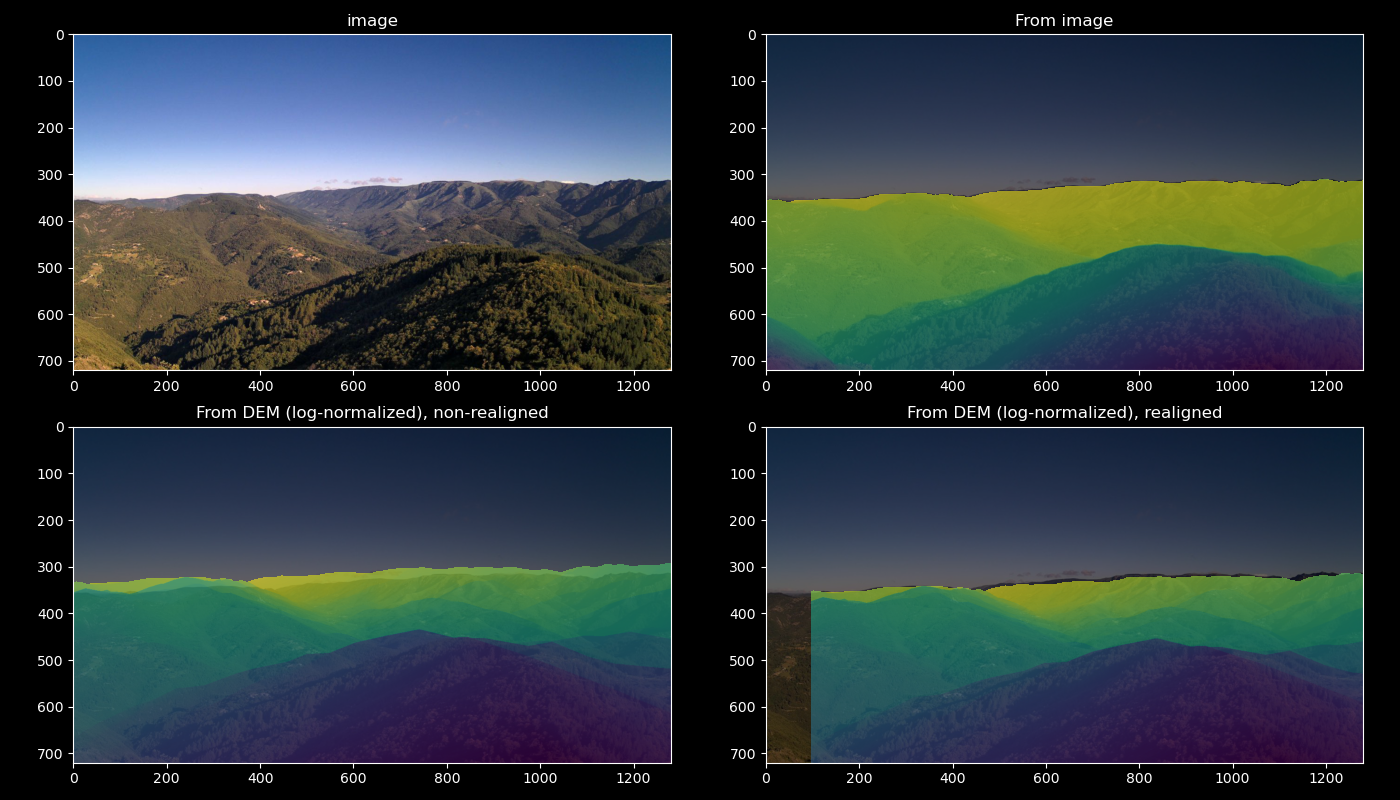

In [21]:
yaw_shift, pitch_shift, roll_shift = geocam.evaluate_ypr_correction(test_img_path, debug=True)

Comparaison du GCP et de sa projection par le nouveau modèle de caméra corrigé

In [23]:
cam_view_x_angle, cam_view_y_angle = 87, 44
cam_roll = 0

cam_model_corr = CTCameraModel(
    test_img_res,
    cam_view_x_angle,
    cam_view_y_angle,
    cam_info.azimuth - yaw_shift,
    cam_info.pitch,
    cam_roll,
    cam_info.lat,
    cam_info.lon,
    cam_info.elevation,
)

geocam_corr = GeoRefCam(cam_model_corr, dem)

test_gcp_idx = 2
pixel_points = gdf_annot_gcp.loc[test_gcp_idx, ["posx", "posy"]]
# pixel_points = gdf_annot_gcp[["posx", "posy"]]

rays = geocam_corr.camera_model.project_pixel_points_to_world_rays(pixel_points)
filtered_inter_points, filtered_inter_triangles, df_ray = geocam_corr.cast_rays(
                rays, check_crs=True, min_d_intersection_m=50, return_df_ray=True, cast_method="seq", max_cp_time_s=30)

with open(terrain_dir+"asc_ctcam_proj_corr_ypr.pkl", "wb") as f:
    pickle.dump([df_ray, gdf_annot_gcp, gdf_dalles, test_gcp_idx, yaw_shift, pitch_shift, roll_shift], f)

df_ray

,ori_x,ori_y,ori_z,dest_x,dest_y,dest_z,inter_x,inter_y,inter_z,n_tri,dist_o
n_ray,,,,,,,,,,,
0,796636.658666,6.383642e+06,780.0,788750.509749,6.397402e+06,0.0,794180.1875,6387928.5,537.037109,61301,4946.156335


Pour le moment, réinitialiser le setup pour le plot de démo est nécessaire à cause de kernel crashes causés par le calcul d'intersection de rayon

In [24]:
dalles_shape_file = Path("dalles.shp")
gdf_dalles = gpd.read_file(carto_dir / dalles_dir / dalles_shape_file)

cam_file = camdata_dir / "API_DATA - devices.csv"
df_cams = pd.read_csv(cam_file)
gdf_cams = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_cams.lon, df_cams.lat, crs="WGS84"), data=df_cams)

cam_info = gdf_cams[gdf_cams.login == cam_name].squeeze()
test_img_path = camdata_dir / cam_name / test_img_name
test_img = Image.open(test_img_path)
test_img_res = test_img.size

gdf_dalles_wgs84 = gdf_dalles.to_crs("WGS84")
dalle_cam = gdf_dalles[gdf_dalles_wgs84.geometry.contains(cam_info.geometry)].squeeze()
nom_dalle = dalle_cam.NOM_DALLE
dalle_file = carto_dir / donnees_dir / Path(f"{nom_dalle}.asc")

with open(terrain_dir+"asc_ctcam_proj_corr_ypr.pkl", "rb") as f:
    df_ray, gdf_annot_gcp, gdf_dalles, test_gcp_idx, yaw_shift, pitch_shift, roll_shift = pickle.load(f)
with open(terrain_dir+"dem_asc.pkl", "rb") as f:
    dem = pickle.load(f)


cam_view_x_angle, cam_view_y_angle = 87, 44
cam_roll = 0

cam_model_corr = CTCameraModel(
    test_img_res,
    cam_view_x_angle,
    cam_view_y_angle,
    cam_info.azimuth - yaw_shift,
    cam_info.pitch,
    cam_roll,
    cam_info.lat,
    cam_info.lon,
    cam_info.elevation,
)
geocam_corr = GeoRefCam(cam_model_corr, dem)

project_points_to_crs(df_ray.loc[0, ["inter_x", "inter_y", "inter_z"]].to_numpy(), dem.crs, "wgs84")

array([[ 44.58407232,   4.18642562, 537.03710938]])

In [ ]:
plot_margin_m = 1000

alts_meshgrid = dem.pcd

target_point = np.array(list(gdf_annot_gcp.to_crs(gdf_dalles.crs).loc[test_gcp_idx, "geometry"].coords)[0])
origin = df_ray.loc[0, ["ori_x", "ori_y", "ori_z"]].to_numpy(dtype=float)
destination = df_ray.loc[0, ["dest_x", "dest_y", "dest_z"]].to_numpy(dtype=float)
inter_point = df_ray.loc[0, ["inter_x", "inter_y", "inter_z"]].to_numpy(dtype=float)

intersection_found = ~np.isnan(inter_point[0])

if intersection_found:
    points_of_interest = np.vstack((target_point, origin, inter_point))
else:
    points_of_interest = np.vstack((target_point, origin))
(x_min, y_min, _) = points_of_interest.min(axis=0) - plot_margin_m
(x_max, y_max, _) = points_of_interest.max(axis=0) + plot_margin_m

zone_mask_idx = np.vstack(((alts_meshgrid[:, :, 0] > x_min) & (alts_meshgrid[:, :, 0] < x_max) & (alts_meshgrid[:, :, 1] > y_min) & (alts_meshgrid[:, :, 1] < y_max)).nonzero())
x_min_idx, y_min_idx = zone_mask_idx.min(axis=1)
x_max_idx, y_max_idx = zone_mask_idx.max(axis=1)
# plot_meshgrid = alts_meshgrid[x_min_idx:x_max_idx, y_min_idx:y_max_idx, :]
plot_meshgrid = alts_meshgrid

plot_pv_meshgrid = pv.StructuredGrid(*[plot_meshgrid[:, :, i] for i in range(3)])
plot_pv_meshgrid["alt"] = plot_meshgrid[:, :, 2].ravel(order="F")  # add the altitude as a scalar field in order to plot it as a colormap

bar_height_m = round(max(abs(alts_meshgrid[0, x_max_idx, 0] - alts_meshgrid[0, x_min_idx, 0]), abs(alts_meshgrid[y_max_idx, 0, 1] - alts_meshgrid[y_min_idx, 0, 1])) / 10)
target_plumb_line = pv.Line(target_point, target_point + np.array([0, 0, bar_height_m]))
camera_plumb_line = pv.Line(origin, origin + np.array([0, 0, bar_height_m]))
if intersection_found:
    intersection_plumb_line = pv.Line(inter_point, inter_point + np.array([0, 0, bar_height_m]))
    ray_cut = pv.Line(origin, inter_point)
    target_inter_separation_line = pv.Line([target_point[0], target_point[1], max(target_point[2], inter_point[2])], [inter_point[0], inter_point[1], max(target_point[2], inter_point[2])])
    intersection = pv.PolyData(inter_point)
else:
    ray_cut = pv.Line(origin, destination)

plotter = pv.Plotter()
plotter.add_mesh(plot_pv_meshgrid, smooth_shading=True, specular=0.5, specular_power=15)

plotter.add_mesh(camera_plumb_line, color="red", line_width=2, opacity=1, label="camera plumb line")
plotter.add_mesh(ray_cut, color="orange", line_width=2, opacity=1, label="ray segment")
plotter.add_mesh(target_plumb_line, color="yellow", line_width=2, opacity=1, label="target plumb line")
if intersection_found:
    plotter.add_mesh(intersection_plumb_line, color="lightgreen", line_width=2, opacity=1, label="intersection point plumb line")
    plotter.add_mesh(target_inter_separation_line, color="cyan", line_width=2, opacity=1,
                     label=f"horizontal intersection-target separation: {np.linalg.norm(inter_point[:2] - target_point[:2]):.1f} m")
    plotter.add_mesh(intersection, color="maroon", point_size=5, label="intersection point")
plotter.add_legend()
plotter.show()